## Analysis of stock prices using PCA

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext

#sc.stop()
sc = SparkContext(master="local[6]",pyFiles=['lib/spark_PCA.py'])

from pyspark.sql import *
sqlContext = SQLContext(sc)

%pylab inline
import sys
sys.path.append('./lib')

import numpy as np
from spark_PCA import computeCov

Populating the interactive namespace from numpy and matplotlib


In [2]:
# read the file in a dataframe.
df=sqlContext.read.csv('SP500.csv',header='true',inferSchema='true')
df.count()

13422

In [3]:
columns=df.columns
col=[c for c in columns if '_D' in c]

Extract the tickers from the column names of `df`

In [4]:
tickers = map(lambda x: x[:x.index('_D')], col)
tickers[:10],len(tickers)

(['AGN', 'EOG', 'WLP', 'CPB', 'YUM', 'JWN', 'FLS', 'TAP', 'BWA', 'AAPL'], 476)

#### Create an RDD of numpy arrays


In [5]:
def make_array(row):
    arr = np.array([row['{}_D'.format(tickers[i])] for i in range(len(tickers))], dtype=np.float64)
    return np.nan_to_num(arr)

Rows = df.select(col).rdd.map(make_array).cache()
Rows.first()[:20]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.00830103,  0.        ,  0.        ,  0.        ])

In [1]:
# Run ComputeCov to create the covariance matrix.
OUT=computeCov(Rows)
OUT.keys()

NameError: name 'computeCov' is not defined

In [7]:
from numpy import linalg as LA
eigval,eigvec=LA.eigh(OUT['Cov'])
eigval=eigval[-1::-1] # reverse order
eigvec=eigvec[:,-1::-1]

### Percentage-of-variance explained graph
The percentage of variance explained as a function of the number of top eigen-vectors used.

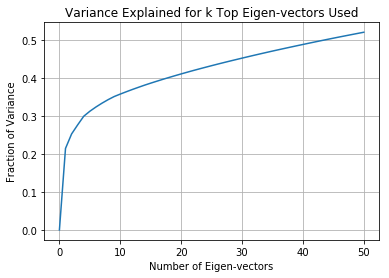

In [8]:
def plotVarExplained(EV, k):
    plot(([0] + list(cumsum(EV[:k])))/sum(EV))
    title('Variance Explained for k Top Eigen-vectors Used')
    ylabel('Fraction of Variance')
    xlabel('Number of Eigen-vectors')
    grid()
plotVarExplained(eigval, 50)

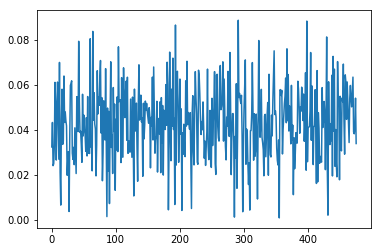

In [9]:
plot(eigvec[:, 0])

### Performing K-NN on sectors.
1. Project the daily change sequences of all stocks on the top $d$ eigenvectors to get a vector in $R^d$.
2. Find the $k$ closest neighbors to the unknown stock, and find the plurality label (the plurality label is the one that appears the largest number of times amond the $k$ neighbors. As there are more than 2 labels, it is possible that the plurality label is not the majority.)

In [10]:
import pickle
D=pickle.load(open('Tickers.pkl','rb'))
TickerInfo=D['TickerInfo']
TickerInfo.head()

tickersToIgnore = ['NSC', 'ABC', 'ROK','MAS', 'APD']
print len(tickers)    

# list all companies in the Energy sector
TickerInfo[TickerInfo['SECTOR_ID']=='EN']

476


,Ticker,Name,Sector,SECTOR_ID
41,APC,Anadarko Petroleum|Anadarko Petroleum Corp,Energy,EN
45,APA,Apache Corporation,Energy,EN
60,BHI,Baker Hughes Inc,Energy,EN
83,COG,Cabot Oil & Gas,Energy,EN
101,CHK,Chesapeake Energy,Energy,EN
102,CVX,Chevron Corp.,Energy,EN
107,XEC,Cimarex Energy,Energy,EN
124,CXO,Concho Resources,Energy,EN
125,COP,ConocoPhillips,Energy,EN
145,DVN,Devon Energy,Energy,EN


In [11]:
def calc_sectors(tickers):
    sectors = []
    for t in tickers:
        try: 
            sectors.append(TickerInfo[TickerInfo['Ticker'] == t]['SECTOR_ID'].item())
        except:
            sectors.append(t)
    return sectors
sectors = calc_sectors(tickers)

In [12]:
# Create a dictionary that maps each ticker to the corresponding basis vector
Tick_rep={}
for i in range(len(tickers)):
    Tick_rep[tickers[i]]=eigvec[i,:] * eigval[i]

In [13]:
len(sectors)

476

`find_closest` takes a query ticker, d and k as input and returns a sorted list of tickers, their sectors, and their distance from the query ticker.

For example:
```python 
find_closest('HAL') 
```
should return 

```
[('HAL', 'EN', 0.0),
 ('SLB', 'EN', 0.0054474558470919412),
 ('APA', 'EN', 0.0095375619627422019),
 ('HP', 'EN', 0.0095667138343728166),
 ('BHI', 'EN', 0.01280991458941858),
 ('RDC', 'RDC', 0.012865326588403255),
 ('NBL', 'EN', 0.01654306862676054),
 ('APC', 'EN', 0.019824473381124783),
 ('COP', 'EN', 0.020783142716246431),
 ('ETR', 'UTIL', 0.021988972018102161),
 ('DO', 'DO', 0.022236500402408065)]
```

Similarly for bank of america:
```python
find_closest('BAC')
```

```
[('BAC', 'FIN', 0.0),
 ('AIG', 'FIN', 0.1166233109896993),
 ('STI', 'FIN', 0.1390683030203888),
 ('FITB', 'FIN', 0.1479186255365789),
 ('C', 'FIN', 0.1710861632442088),
 ('KEY', 'FIN', 0.18822247596796085),
 ('RF', 'FIN', 0.19362473601644403),
 ('HBAN', 'FIN', 0.19807819614960992),
 ('WFC', 'FIN', 0.2322604278432217),
 ('PNC', 'FIN', 0.32297570683407145)]
 ```

In [19]:
d=20
k=5
T='HAL'

l2squared = lambda x: (np.sum(np.square(x)))
        
def find_closest(T,d=10,k=10):

    index = tickers.index(T)
    
    U_basis = np.mat([eigvec[:,i] for i in range(d)], dtype=float64).T
    U_prime = np.mat([eigvec[:,i] for i in range(d)], dtype=float64)
    U = Rows.map(lambda (r): np.dot(r, U_basis))

    X = U.map(lambda r: np.matmul(r, U_prime))\
         .map(lambda r: np.square(r - r[:,index].item()))\
         .sum()

    dist = []
    for i in range(len(tickers)):
        tick = tickers[i]
        dist.append((tick, sectors[i], X[:,i].item()))
    dist.sort(key=lambda (x,y,z): z)
    return dist[:k]

find_closest('BAC')

[('BAC', 'FIN', 0.0),
 ('AIG', 'FIN', 0.1166233109896993),
 ('STI', 'FIN', 0.1390683030203888),
 ('FITB', 'FIN', 0.1479186255365789),
 ('C', 'FIN', 0.1710861632442088),
 ('KEY', 'FIN', 0.18822247596796085),
 ('RF', 'FIN', 0.19362473601644403),
 ('HBAN', 'FIN', 0.19807819614960992),
 ('WFC', 'FIN', 0.2322604278432217),
 ('PNC', 'FIN', 0.32297570683407145)]